In [18]:
# Importujeme si opět knihovny jako minule
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

from keras import layers
# %matplotlib ipympl

TensorFlow version: 2.16.2
Keras version: 3.5.0


In [19]:
# Budeme pracovat s datasetem MNIST, který obsahuje obrázky ručně psaných číslic 0-9
# Odkaz na stránku datasetu: Odkaz na informace o datasetu z Keras: https://keras.io/api/datasets/mnist/
# https://yann.lecun.com/exdb/mnist/
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [20]:
class_distribution = pd.DataFrame(np.unique(y_train, return_counts=True)).T
class_distribution.columns = ['Number', 'Count']
class_distribution["Percentage"] = (class_distribution["Count"] / len(y_train)) * 100
class_distribution["Percentage"] = class_distribution['Percentage'].astype(float).map("{:.2f}%".format)
class_distribution

,Number,Count,Percentage
0,0,5923,9.87%
1,1,6742,11.24%
2,2,5958,9.93%
3,3,6131,10.22%
4,4,5842,9.74%
5,5,5421,9.04%
6,6,5918,9.86%
7,7,6265,10.44%
8,8,5851,9.75%
9,9,5949,9.92%


array([  0,   0,   0,   0,   0,   0,   0,   0,   0,  14,   1, 154, 253,
        90,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=uint8)

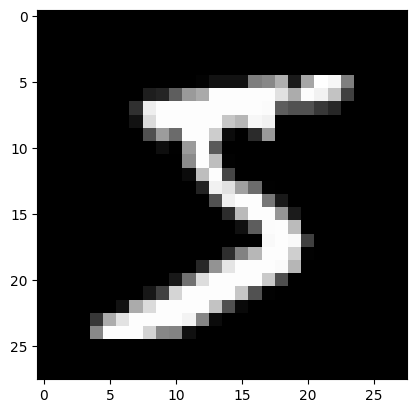

In [21]:
first_digit = x_train[0]
plt.imshow(first_digit, cmap='gray')

first_digit[10,:] # 11. řádek vypadá nějak takto

In [22]:
from keras.utils import to_categorical

# Hodnoty v matici jsou od 0 do 255. Chceme je převést na hodnoty od 0 do 1
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255

# One-hot encoding pro target atribut
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [23]:
# Nejprve si ukážeme, že lze použít i klasický model. Pro malé obrázky tento přístup "funguje".
model = keras.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

model.summary()

/Users/hradzpisku/Documents/Projects/UMIN/.venv/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,770 (397.54 KB)

 Trainable params: 101,770 (397.54 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
trained = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=128,
    verbose=0,
    validation_split=0.2
)

acc         0.998604
loss        0.008421
val_acc     0.975500
val_loss    0.094790
Name: 19, dtype: float64

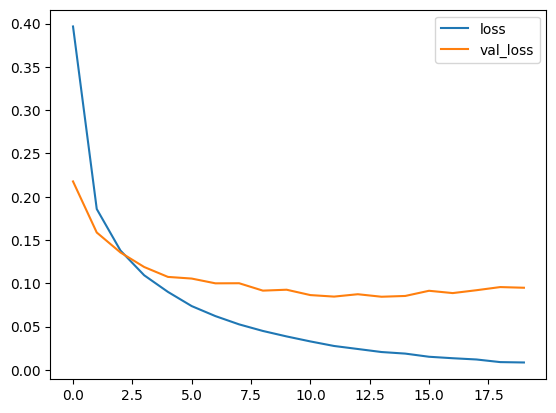

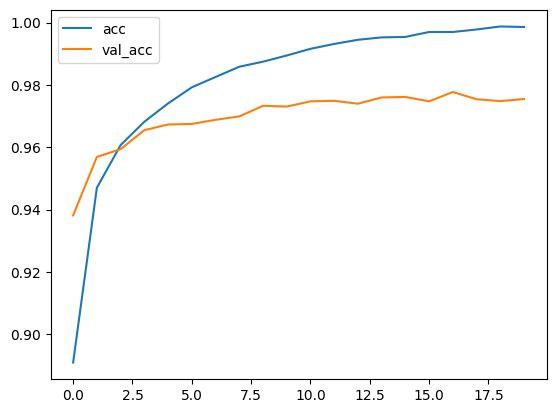

In [25]:
history = pd.DataFrame(trained.history)

history.loc[:, ['loss', 'val_loss']].plot()
history.loc[:, ['acc', 'val_acc']].plot()

# V poslední epoše.
history.iloc[-1]

# Overfitting je zřejmý, ale pro účely ukázky to nevadí.

In [26]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.08506926894187927
Test accuracy: 0.9763000011444092


In [28]:
# Nyní si ukážeme, jak použít konvoluční neuronovou síť.
model = keras.Sequential([
    # Convilutional base
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    # Convilutional base
    layers.Flatten(),
    # Classifier
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
    # Classifier
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
trained = model.fit(
    x_train, y_train,
    epochs=20,
    batch_size=128,
    verbose=0,
    validation_split=0.2
)

acc         0.999563
loss        0.001579
val_acc     0.991500
val_loss    0.046372
Name: 19, dtype: float64

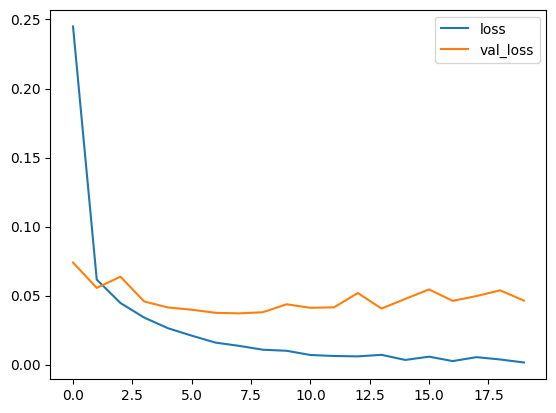

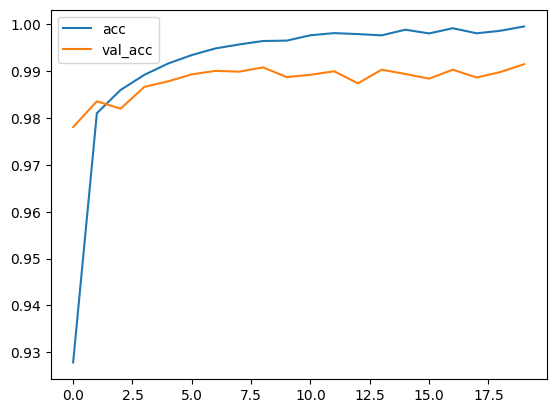

In [30]:
history = pd.DataFrame(trained.history)

history.loc[:, ['loss', 'val_loss']].plot()
history.loc[:, ['acc', 'val_acc']].plot()

# V poslední epoše.
history.iloc[-1]

In [31]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.03818821907043457
Test accuracy: 0.9918000102043152


In [1]:
# Teď si můžeme ukázat složitější příklad.